Company XYZ has started a new referral program on **Oct, 31**. Each user who refers a new user will get 10$ in credit when the new user buys something. The program has been running for almost a month and the Growth Product Manager wants to know if it's been successful. She is very excited cause, since the referral program started, the company saw a spike in number of users and wants you to be able to give her some data she can show to her boss.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('referral.csv' )
df

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH
...,...,...,...,...,...,...
97336,19934,2015-11-27,UK,35,1,AWMDRMOFTSZIH
97337,19941,2015-11-27,DE,31,1,QAUSDXXLVUERE
97338,19948,2015-11-27,UK,22,1,DCYLHYFLMRODO
97339,19953,2015-11-27,UK,35,1,LROILUYWCNVWQ


In [3]:
# this dataset doesn't have missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      97341 non-null  int64 
 1   date         97341 non-null  object
 2   country      97341 non-null  object
 3   money_spent  97341 non-null  int64 
 4   is_referral  97341 non-null  int64 
 5   device_id    97341 non-null  object
dtypes: int64(3), object(3)
memory usage: 4.5+ MB


## Data Processing

In [5]:
# convert date into datetime format
df['date'] = pd.to_datetime(df['date'])

In [6]:
# create a column only contains month and day
df['month_day'] = df['date'].apply(lambda x: str(x)[5:10])

In [7]:
# day of week
df['day_of_week'] = df['date'].dt.dayofweek
# becuase dt.dayofweek set Monday as 0, Tuesday as 1 so on.. , so I change it from 0-6 to 1-7, it's more intuitive
df['day_of_week'] = df['day_of_week'].map({0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7})

In [8]:
from datetime import datetime

# The new referral program started on Oct, 31th. 
first_day_program = '2015-10-31'
first_day_program = pd.to_datetime(first_day_program)

# create a new column to indicate this transcation in the program(after Oct, 31th) or not.
df['in_program'] = df.apply(lambda x: 1 if x['date'] >= first_day_program else 0, axis=1)

In [9]:
df.sample(6)

,user_id,date,country,money_spent,is_referral,device_id,month_day,day_of_week,in_program
60353,3390,2015-11-07,US,10,0,MXRYPRAQKPDII,11-07,6,1
76794,7471,2015-11-15,US,56,1,ZAMKYOSQVZFOC,11-15,7,1
42973,1281,2015-10-27,IT,45,0,ZPZRQZHXBPKTI,10-27,2,0
81887,12062,2015-11-18,CA,13,1,DHAUARFXUIQJB,11-18,3,1
31114,1584,2015-10-20,US,58,0,QCDTSXNLGKEII,10-20,2,0
14768,4968,2015-10-10,DE,52,0,JDKSDPFMTCKHZ,10-10,6,0


In [10]:
print('Number of records before program: ', df.loc[df['in_program']==0,:].shape[0])
print('Number of days before program: ', len(df.loc[df['in_program']==0,:]['date'].unique()))
print(' ')
print('Number of records in program: ', df.loc[df['in_program']==1,:].shape[0])
print('Number of days in program: ', len(df.loc[df['in_program']==1,:]['date'].unique()))
print(' ')
print('Total User: ', df['user_id'].unique().shape[0])
print('Total Country: ',df['country'].unique().shape[0])
print('Total Country: ',df['device_id'].unique().shape[0])

Number of records before program:  47341
Number of days before program:  28
 
Number of records in program:  50000
Number of days in program:  28
 
Total User:  18809
Total Country:  9
Total Country:  17887


## Data Visulization

### (1) Date

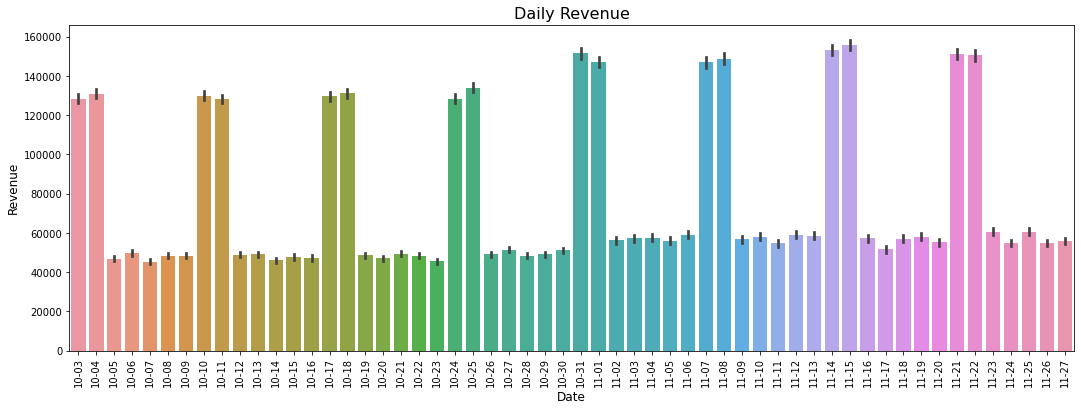

In [11]:
fig, ax = plt.subplots(figsize=(18,6))

# Average daily spent
sns.barplot(x='month_day', y='money_spent', estimator=sum, data=df)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Revenue', fontsize=12)
ax.set_title('Daily Revenue', fontsize=16)
plt.xticks(rotation=90)

plt.show()

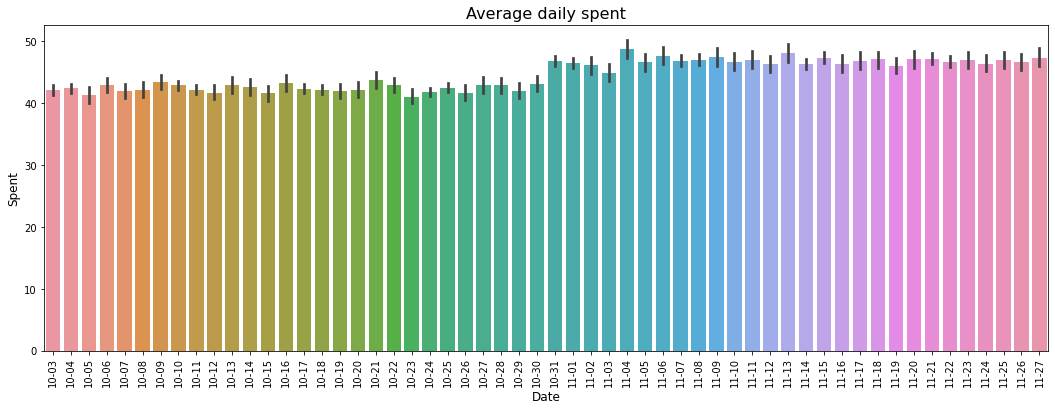

In [12]:
fig, ax = plt.subplots(figsize=(18,6))

# Average daily spent
sns.barplot(x='month_day', y='money_spent', data=df)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Spent', fontsize=12)
ax.set_title('Average daily spent', fontsize=16)
plt.xticks(rotation=90)

plt.show()

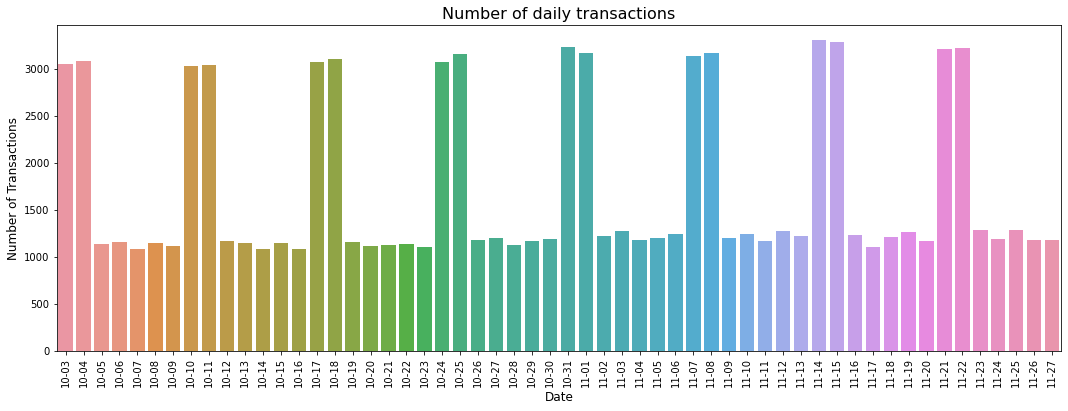

In [13]:
# Number of daily transactions plot
fig, ax = plt.subplots(figsize=(18,6))

sns.countplot(x='month_day', data=df)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.set_title('Number of daily transactions', fontsize=16)
plt.xticks(rotation=90)

plt.show()

#### In daily data visualization:
* we can see increases in revenue, average spent, and number of tansactions after Oct. 31th, but is it significant enough to say that our program is successful? we need further analysis.

### (2) Country

In [14]:
# check each country revenue
revenue_country = df.groupby('country')['money_spent'].sum().reset_index()
revenue_country = revenue_country.rename(columns={'money_spent': 'revenue_country'})
revenue_country

,country,revenue_country
0,CA,429768
1,CH,71686
2,DE,500380
3,ES,428658
4,FR,672567
5,IT,499660
6,MX,336243
7,UK,711479
8,US,699958


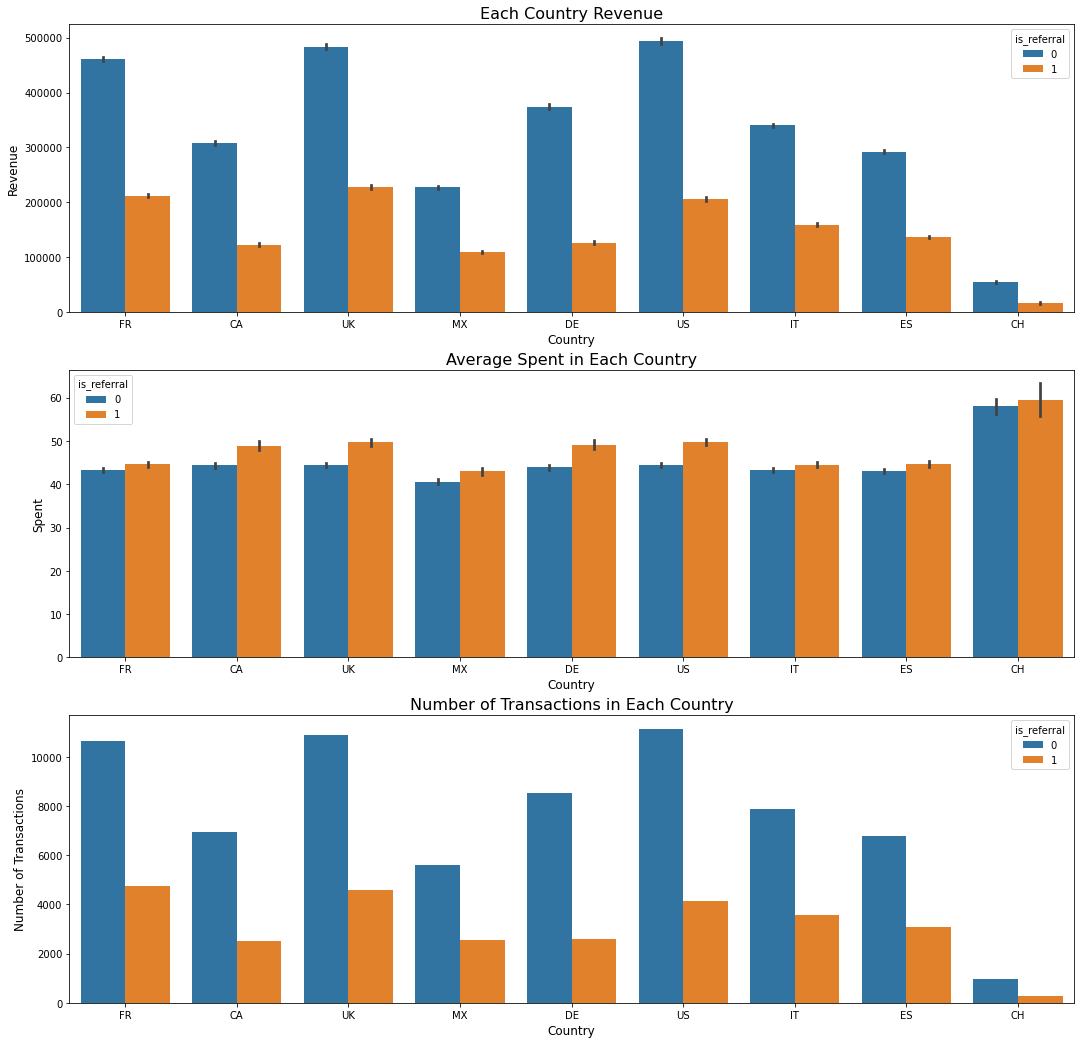

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18,18))

# Each country revenue
sns.barplot(x='country', y='money_spent', hue='is_referral', data=df, estimator=sum,ax=ax[0])
ax[0].set_xlabel('Country', fontsize=12)
ax[0].set_ylabel('Revenue', fontsize=12)
ax[0].set_title('Each Country Revenue', fontsize=16)


# Average country spent
sns.barplot(x='country', y='money_spent', hue='is_referral', data=df, ax=ax[1])
ax[1].set_xlabel('Country', fontsize=12)
ax[1].set_ylabel('Spent', fontsize=12)
ax[1].set_title('Average Spent in Each Country', fontsize=16)

# Number of Transactions in Each Country
sns.countplot(x='country', hue='is_referral', data=df, ax=ax[2])
ax[2].set_xlabel('Country', fontsize=12)
ax[2].set_ylabel('Number of Transactions', fontsize=12)
ax[2].set_title('Number of Transactions in Each Country', fontsize=16)

plt.show()

#### In country data visualization:
1. UK and US generated the most revenue
2. Even CH have a minimum number of transactions, but the average spent in CH is the highest. We can increase our market campaigns and advertising in this country.

## Analysis

In [16]:
def number_info(df):
    ser = {}
    # number of user
    ser['n_user']=df['user_id'].unique().shape[0]
    # total spent
    ser['total_spent']=df['money_spent'].sum()
    # number of transaction
    ser['n_trans']=df.shape[0]
    return pd.Series(ser)

In [17]:
def stat_result(df):
    # get daily number info
    daily_number_info = df.groupby('date').apply(number_info)
    
    # split data into "before program" and "after program"
    before_program = daily_number_info.loc[daily_number_info.index < first_day_program,:]
    after_program = daily_number_info.loc[daily_number_info.index >= first_day_program,:]
    
    
    tem = []
    columns = ['n_user', 'total_spent', 'n_trans']
    # get each column's data and calculate mean in both group
    for i in columns:
        before_data = before_program.loc[:,i]
        before_mean = before_data.mean()

        after_data = after_program.loc[:,i]
        after_mean = after_data.mean()
        
        diff_mean = after_mean - before_mean
        
        # t-test
        result = ttest_ind(before_data, after_data, equal_var=False)
        # we do a two tails test (only more or less)
        pvalue = result.pvalue/2
        
        tem.append({'before_mean':before_mean, 'after_mean':after_mean, 'diff_mean':diff_mean, 'p-value':pvalue})
    return pd.DataFrame(tem, index=columns)  #.loc[:, ['before_mean', 'after_mean', 'diff_mean', 'p-value']]

### (1) Date

In [18]:
stat_result(df).reset_index()

,index,before_mean,after_mean,diff_mean,p-value
0,n_user,1384.464286,1686.964286,302.500000,0.059545
1,total_spent,71657.000000,83714.392857,12057.392857,0.135194
2,n_trans,1690.750000,1785.714286,94.964286,0.348257


### (2) Country

In [19]:
df.groupby('country').apply(stat_result)

before_mean    after_mean    diff_mean   p-value
country                                                               
CA      n_user         173.285714    159.178571   -14.107143  0.268256
        total_spent   7468.428571   7880.428571   412.000000  0.351704
        n_trans        177.142857    160.000000   -17.142857  0.233985
CH      n_user          26.714286     17.071429    -9.642857  0.003142
        total_spent   1536.321429   1023.892857  -512.428571  0.006941
        n_trans         26.821429     17.071429    -9.750000  0.003072
DE      n_user         224.964286    163.250000   -61.714286  0.015665
        total_spent   9856.750000   8013.964286 -1842.785714  0.081459
        n_trans        232.142857    164.035714   -68.107143  0.011798
ES      n_user         153.392857    193.214286    39.821429  0.057954
        total_spent   6648.642857   8660.571429  2011.928571  0.037522
        n_trans        156.607143    194.500000    37.892857  0.072638
FR      n_user         236.500000    302.535714    66.035714  0.041124
        total_spent  10385.250000  13635.000000  3249.750000  0.031843
        n_trans        244.142857    305.714286    61.571429  0.058996
IT      n_user         176.535714    226.107143    49.571429  0.043911
        total_spent   7651.571429  10193.428571  2541.857143  0.025730
        n_trans        180.857143    227.928571    47.071429  0.057454
MX      n_user         124.392857    163.107143    38.714286  0.026203
        total_spent   4975.464286   7033.214286  2057.750000  0.009670
        n_trans        126.464286    164.000000    37.535714  0.032430
UK      n_user         255.571429    286.321429    30.750000  0.204398
        total_spent  11213.535714  14196.428571  2982.892857  0.048490
        n_trans        264.285714    289.035714    24.750000  0.261183
US      n_user         273.178571    261.107143   -12.071429  0.368860
        total_spent  11921.035714  13077.464286  1156.428571  0.248874
        n_trans        282.285714    263.428571   -18.857143  0.307801

# Question 01
Can you estimate the impact the program had on the site?

#### Ans:
* On the whole, there was no significant difference in user referral program, the number of user increase, but the total spent and number of transcation do not increase

But, there are some differences between contries:
1. In CH and DE, the program is fail, the total sales decrease
2. In ES, FR, IT, and MX, the program is succesful, the total sales increase
3. In CA, UK, and US, the program does not make a significant impact

# Question 02
Based on the data, what would you suggest to do as a next step?

#### Ans:
1. I suggest to do a more accurate A/B test, exclude other factors that could potentially affect our experiment result and collect more data, so that we can do better analysis
2. The program make different impact in different country, we should find out the reason for the differences. For example, in CH and DE, maybe there are some local competitors offer better referral program. Or, maybe there's some seasonal spending habit that happens in November (save money for December?) Since we only run this program for 1 month, this reason can affect the result a lot.

# Question 03
The referral program wasn't really tested in a rigorous way. It simply started on a given day for all users and you are drawing conclusions by looking at the data before and after the test started. What kinds of risks this approach presents? Can you think of a better way to test the referral program and measure its impact?

#### Ans:
This approach isn't an accurate A/B test. "User Referral" program isn't the only factor that affect control group and test group. To get more accurate result, we need to perform a more strict A/B test. 

For example:

1. Set up the experiment in the same peroid of time
2. Randomly sample users into two groups, and let only one group user know the User Referral program.
3. Run the experiment in a while, then do the t-test to see whether some 'sale performance index' (e.g., daily spent, daily customers, daily transactions) have significant changes or not.